# INT15 FINAL PROJECT

## Due Date:  June 12, midnight

<span style="color:red">
    <h1> Examining the Keys to Successful Music </h1>
</span>

<span style="color:blue">
<h2> Names: Jake Kaihewalu and Jasmine Kellogg </h2>
</span>

# Spotify and Pitchfork Album Data Analysis

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing 
import datetime 
import difflib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
reviews = pd.read_csv('reviews.csv')
acoustic = pd.read_csv('acoustic_features.csv')
albums = pd.read_csv('albums.csv')
sent = pd.read_csv('vader_lexicon.txt', sep = '\t', index_col = [0], usecols = [0, 1], header = None, names = ['token', 'polarity'])
print(acoustic.columns)
print(reviews.columns)
print(albums.columns)

Index(['index', 'id', 'song', 'album', 'artist', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'album_id', 'date'],
      dtype='object')
Index(['index', 'id', 'artist', 'album', 'genre', 'score', 'date', 'author',
       'role', 'review', 'bnm', 'link'],
      dtype='object')
Index(['index', 'id', 'date', 'artist', 'album', 'rank', 'length',
       'track_length'],
      dtype='object')


## Checking NA's
Before manipulating the data, we did a check for null values to see what we were working with. 

In [13]:
#check for missing data 
print(reviews.isnull().sum())
print(acoustic.isnull().sum())
print(albums.isnull().sum())

index        0
id           0
artist       1
album        3
genre     2305
score        0
date         0
author       0
role      3498
review       2
bnm          0
link         0
dtype: int64
index                0
id                   0
song                 0
album                0
artist              51
acousticness         5
danceability         5
duration_ms          5
energy               5
instrumentalness     5
key                  5
liveness             5
loudness             5
mode                 5
speechiness          5
tempo                5
time_signature       5
valence              5
album_id             0
date                 0
dtype: int64
index                0
id                   0
date                 1
artist              65
album                1
rank                 1
length           81400
track_length    105080
dtype: int64


## Manipulating and Cleaning Data

For the purposes of our project, we dropped variables from `reviews` and `acoustic` that were not relevant, then we merged the two.

### Reviews

In [14]:
#drop unwanted columns
reviews = reviews.drop(columns=['id', 'index', 'role', 'bnm', 'link'])
#convert time to datetime format
reviews['date'] = pd.to_datetime(reviews['date'])
reviews.head()

,artist,album,genre,score,date,author,review
0,David Byrne,“…The Best Live Show of All Time” — NME EP,Rock,5.5,2019-01-11,Andy Beta,"Viva Brother, Terris, Mansun, the Twang, Joe L..."
1,DJ Healer,Lost Lovesongs / Lostsongs Vol. 2,Electronic,6.2,2019-01-11,Chal Ravens,"The Prince of Denmark—that is, the proper prin..."
2,Jorge Velez,Roman Birds,Electronic,7.9,2019-01-10,Philip Sherburne,"Jorge Velez has long been prolific, but that’s..."
3,Chandra,Transportation EPs,Rock,7.8,2019-01-10,Andy Beta,When the Avalanches returned in 2016 after an ...
4,The Chainsmokers,Sick Boy,Electronic,3.1,2019-01-09,Larry Fitzmaurice,We’re going to be stuck with the Chainsmokers ...


### Acoustics

In [15]:
acoustic.head(5)

,index,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
0,0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
3,3,1wJRveJZLSb1rjhnUHQiv6,Swervin (feat. 6ix9ine),Hoodie SZN,A Boogie Wit da Hoodie,0.0153,0.581,189487.0,0.662,0.000000,9.0,0.111,-5.239,1.0,0.303,93.023,4.0,0.434,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
4,4,0jAfdqv18goRTUxm3ilRjb,Startender (feat. Offset and Tyga),Hoodie SZN,A Boogie Wit da Hoodie,0.0235,0.736,192779.0,0.622,0.000000,6.0,0.151,-4.653,0.0,0.133,191.971,4.0,0.506,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


In [16]:
#group acoustic on artist and album and take the means of relevant features, then drop NA's
acoustics_dropped = acoustic.groupby(['artist','album']).agg(np.mean)[['liveness', 'valence', 'danceability', 'acousticness','energy','instrumentalness','loudness','speechiness','tempo','key']]
acoustics_dropped = acoustics_dropped.dropna(axis=0,how='any')
acoustics_dropped.head()

liveness   valence  danceability  \
artist              album                                            
!!! (Chk Chk Chk)   Myth Takes    0.233740  0.561200      0.646500   
"Weird Al" Yankovic Alapalooza    0.186483  0.734250      0.617333   
                    Alpocalypse   0.143817  0.676250      0.635833   
                    Bad Hair Day  0.178708  0.677083      0.602583   
                    Even Worse    0.122418  0.770636      0.716818   

                                  acousticness    energy  instrumentalness  \
artist              album                                                    
!!! (Chk Chk Chk)   Myth Takes        0.091973  0.831800      2.548659e-01   
"Weird Al" Yankovic Alapalooza        0.103543  0.779417      1.455423e-03   
                    Alpocalypse       0.180332  0.582417      1.541667e-07   
                    Bad Hair Day      0.102670  0.689917      8.552500e-06   
                    Even Worse        0.205918  0.649909      3.612727e-06   

                                   loudness  speechiness       tempo       key  
artist              album                                                       
!!! (Chk Chk Chk)   Myth Takes    -6.939000     0.069290  116.136200  5.400000  
"Weird Al" Yankovic Alapalooza    -8.733333     0.055342  126.187750  6.750000  
                    Alpocalypse  -11.030333     0.053600  138.007667  5.166667  
                    Bad Hair Day  -8.451083     0.055700  128.061000  5.833333  
                    Even Worse    -9.848636     0.064791  142.563091  5.363636

### Merge `acoustics_dropped` and `reviews`

In [17]:
acoustics_reviews = pd.merge(acoustics_dropped, reviews, on = ['album'], how = 'inner')
acoustics_reviews.head(5)

,album,liveness,valence,danceability,acousticness,energy,instrumentalness,loudness,speechiness,tempo,key,artist,genre,score,date,author,review
0,Myth Takes,0.233740,0.561200,0.646500,0.091973,0.831800,0.254866,-6.939000,0.069290,116.136200,5.400000,!!!,Rock,8.0,2007-03-02,Brian Howe,With his midriff-baring t-shirts and loose-lim...
1,So Divided,0.222750,0.292200,0.352500,0.271569,0.674917,0.169645,-7.515417,0.052642,127.055333,4.583333,...And You Will Know Us by the Trail of Dead,Rock,5.5,2006-11-15,Matt LeMay,In the four years since the release of their m...
2,Worlds Apart,0.303667,0.342392,0.368583,0.154045,0.674250,0.128157,-7.037583,0.055333,124.805583,5.833333,...And You Will Know Us by the Trail of Dead,Rock,4.0,2005-01-24,Nick Sylvester,Did Source Tags & Codes deserve a 10.0? That's...
3,Pretty Girls Like Trap Music,0.236850,0.319625,0.764188,0.163825,0.663437,0.004051,-4.755750,0.247994,123.552188,4.312500,2 Chainz,Rap,8.0,2017-06-16,Paul A. Thompson,The last song on Pretty Girls Like Trap Music ...
4,Get Ready,0.063900,0.278000,0.752500,0.027090,0.859500,0.047522,-5.676000,0.306000,127.995000,2.500000,New Order,Rock,7.6,2001-11-18,Joe Tangari,It's been a long time since we've heard from N...


Now that we have a clean merge of the two datasets, we'll use sentiment analysis to see if we can get a polarity score from each of the reviews. We will use this score as an additional feature in our model building.

## Pitchfork Review Sentiment Analysis

Here we used VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon sentiment analysis to assign a value for the polarity of each review.

In [18]:
#read in polarity values for each token from vader polarity data
sent = pd.read_csv('vader_lexicon.txt', sep = '\t', index_col = [0], usecols = [0, 1], header = None, names = ['token', 'polarity'])

In [19]:
#add column with reviews that have been normalized to lowercase and no punctuation
punct_re = r'[^\w\s]'
acoustics_reviews['no_punc'] = acoustics_reviews['review'].str.lower().str.replace(punct_re, '')

In [20]:
#create single column tidy format for every word in the review
tidy_format = acoustics_reviews['no_punc'].str.split(expand=True).stack().to_frame().reset_index(level = 1).rename(columns={'level_1':'num',0 :'word'})
tidy_format.head(10)

,num,word
0,0,with
0,1,his
0,2,midriffbaring
0,3,tshirts
0,4,and
0,5,looselimbed
0,6,dance
0,7,moves
0,8,s
0,9,nic


### Creating a new column `polarity` in `acoustics_reviews` 

In [21]:
#add polarity by summing all sentiment scores for a particular review and add to df
acoustics_reviews['polarity'] = tidy_format.merge(sent, how='left', left_on='word', right_index=True).reset_index().fillna(0).groupby('index').apply(np.sum)['polarity']
acoustics_reviews['polarity'].isnull().sum()
acoustics_reviews = acoustics_reviews.dropna(axis=0,how='any')
acoustics_reviews.head()

,album,liveness,valence,danceability,acousticness,energy,instrumentalness,loudness,speechiness,tempo,key,artist,genre,score,date,author,review,no_punc,polarity
0,Myth Takes,0.233740,0.561200,0.646500,0.091973,0.831800,0.254866,-6.939000,0.069290,116.136200,5.400000,!!!,Rock,8.0,2007-03-02,Brian Howe,With his midriff-baring t-shirts and loose-lim...,with his midriffbaring tshirts and looselimbed...,36.0
1,So Divided,0.222750,0.292200,0.352500,0.271569,0.674917,0.169645,-7.515417,0.052642,127.055333,4.583333,...And You Will Know Us by the Trail of Dead,Rock,5.5,2006-11-15,Matt LeMay,In the four years since the release of their m...,in the four years since the release of their m...,10.7
2,Worlds Apart,0.303667,0.342392,0.368583,0.154045,0.674250,0.128157,-7.037583,0.055333,124.805583,5.833333,...And You Will Know Us by the Trail of Dead,Rock,4.0,2005-01-24,Nick Sylvester,Did Source Tags & Codes deserve a 10.0? That's...,did source tags codes deserve a 100 thats not...,12.7
3,Pretty Girls Like Trap Music,0.236850,0.319625,0.764188,0.163825,0.663437,0.004051,-4.755750,0.247994,123.552188,4.312500,2 Chainz,Rap,8.0,2017-06-16,Paul A. Thompson,The last song on Pretty Girls Like Trap Music ...,the last song on pretty girls like trap music ...,37.9
4,Get Ready,0.063900,0.278000,0.752500,0.027090,0.859500,0.047522,-5.676000,0.306000,127.995000,2.500000,New Order,Rock,7.6,2001-11-18,Joe Tangari,It's been a long time since we've heard from N...,its been a long time since weve heard from new...,58.4


In [22]:
acoustics_reviews['polarity'].describe()

count    3229.000000
mean       25.589068
std        25.572302
min      -131.100000
25%        10.600000
50%        25.000000
75%        40.200000
max       139.900000
Name: polarity, dtype: float64

Text(0.5, 1.0, 'Distribution of Pitchfork Review Polarity')

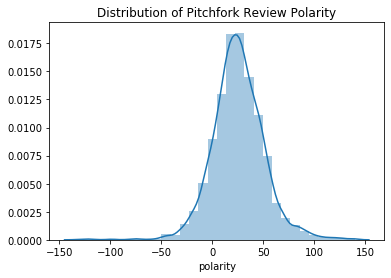

In [23]:
sns.distplot(acoustics_reviews['polarity'], bins = 30)
plt.title('Distribution of Pitchfork Review Polarity')

The polarity seems to have an approximate normal distribution with a mean centered around 23-24.

## Exploratory Analysis 

### Classifying scores

Because `score` is our response variable and there are such a large number of unique values for it, we labeled them by classifying them into five categories.

In [24]:
#classifying scores 
score_num = acoustics_reviews['score']
score_label = []
for current in score_num:
    # Get current value of list
    if (0.0 <= current <= 2.0):
        score_label.append("0-2")
    elif (2.0 < current <= 4.0): 
        score_label.append("2.1-4")
    elif (4.0 < current <= 6.0):
        score_label.append("4.1-6")
    elif (6.0 < current <= 8.0):
        score_label.append("6.1-8")
    else:
        score_label.append("8.1-10")
score_label

['6.1-8',
 '4.1-6',
 '2.1-4',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '6.1-8',
 '2.1-4',
 '6.1-8',
 '4.1-6',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '8.1-10',
 '4.1-6',
 '6.1-8',
 '8.1-10',
 '8.1-10',
 '6.1-8',
 '4.1-6',
 '8.1-10',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',
 '6.1-8',

After we classified the scores, we created a new column for them, `score_label` in the `acoustics_reviews` dataset and created a histogram.

Text(0.5, 1.0, 'Frequency of Binned Scores')

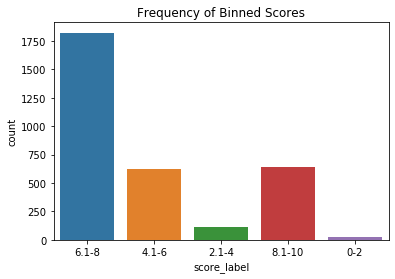

In [25]:
#histogram of classified scores
score_num = score_label 
acoustics_reviews['score_label'] = score_num
sns.countplot(acoustics_reviews['score_label'])
plt.title('Frequency of Binned Scores')

It seems that most albums were above average in their scores, the data is not evenly distributed.

### Pairplot of features 

Using our now full dataset with all relevant variables, we created a pairplot to evaluate linear relationships between variables 

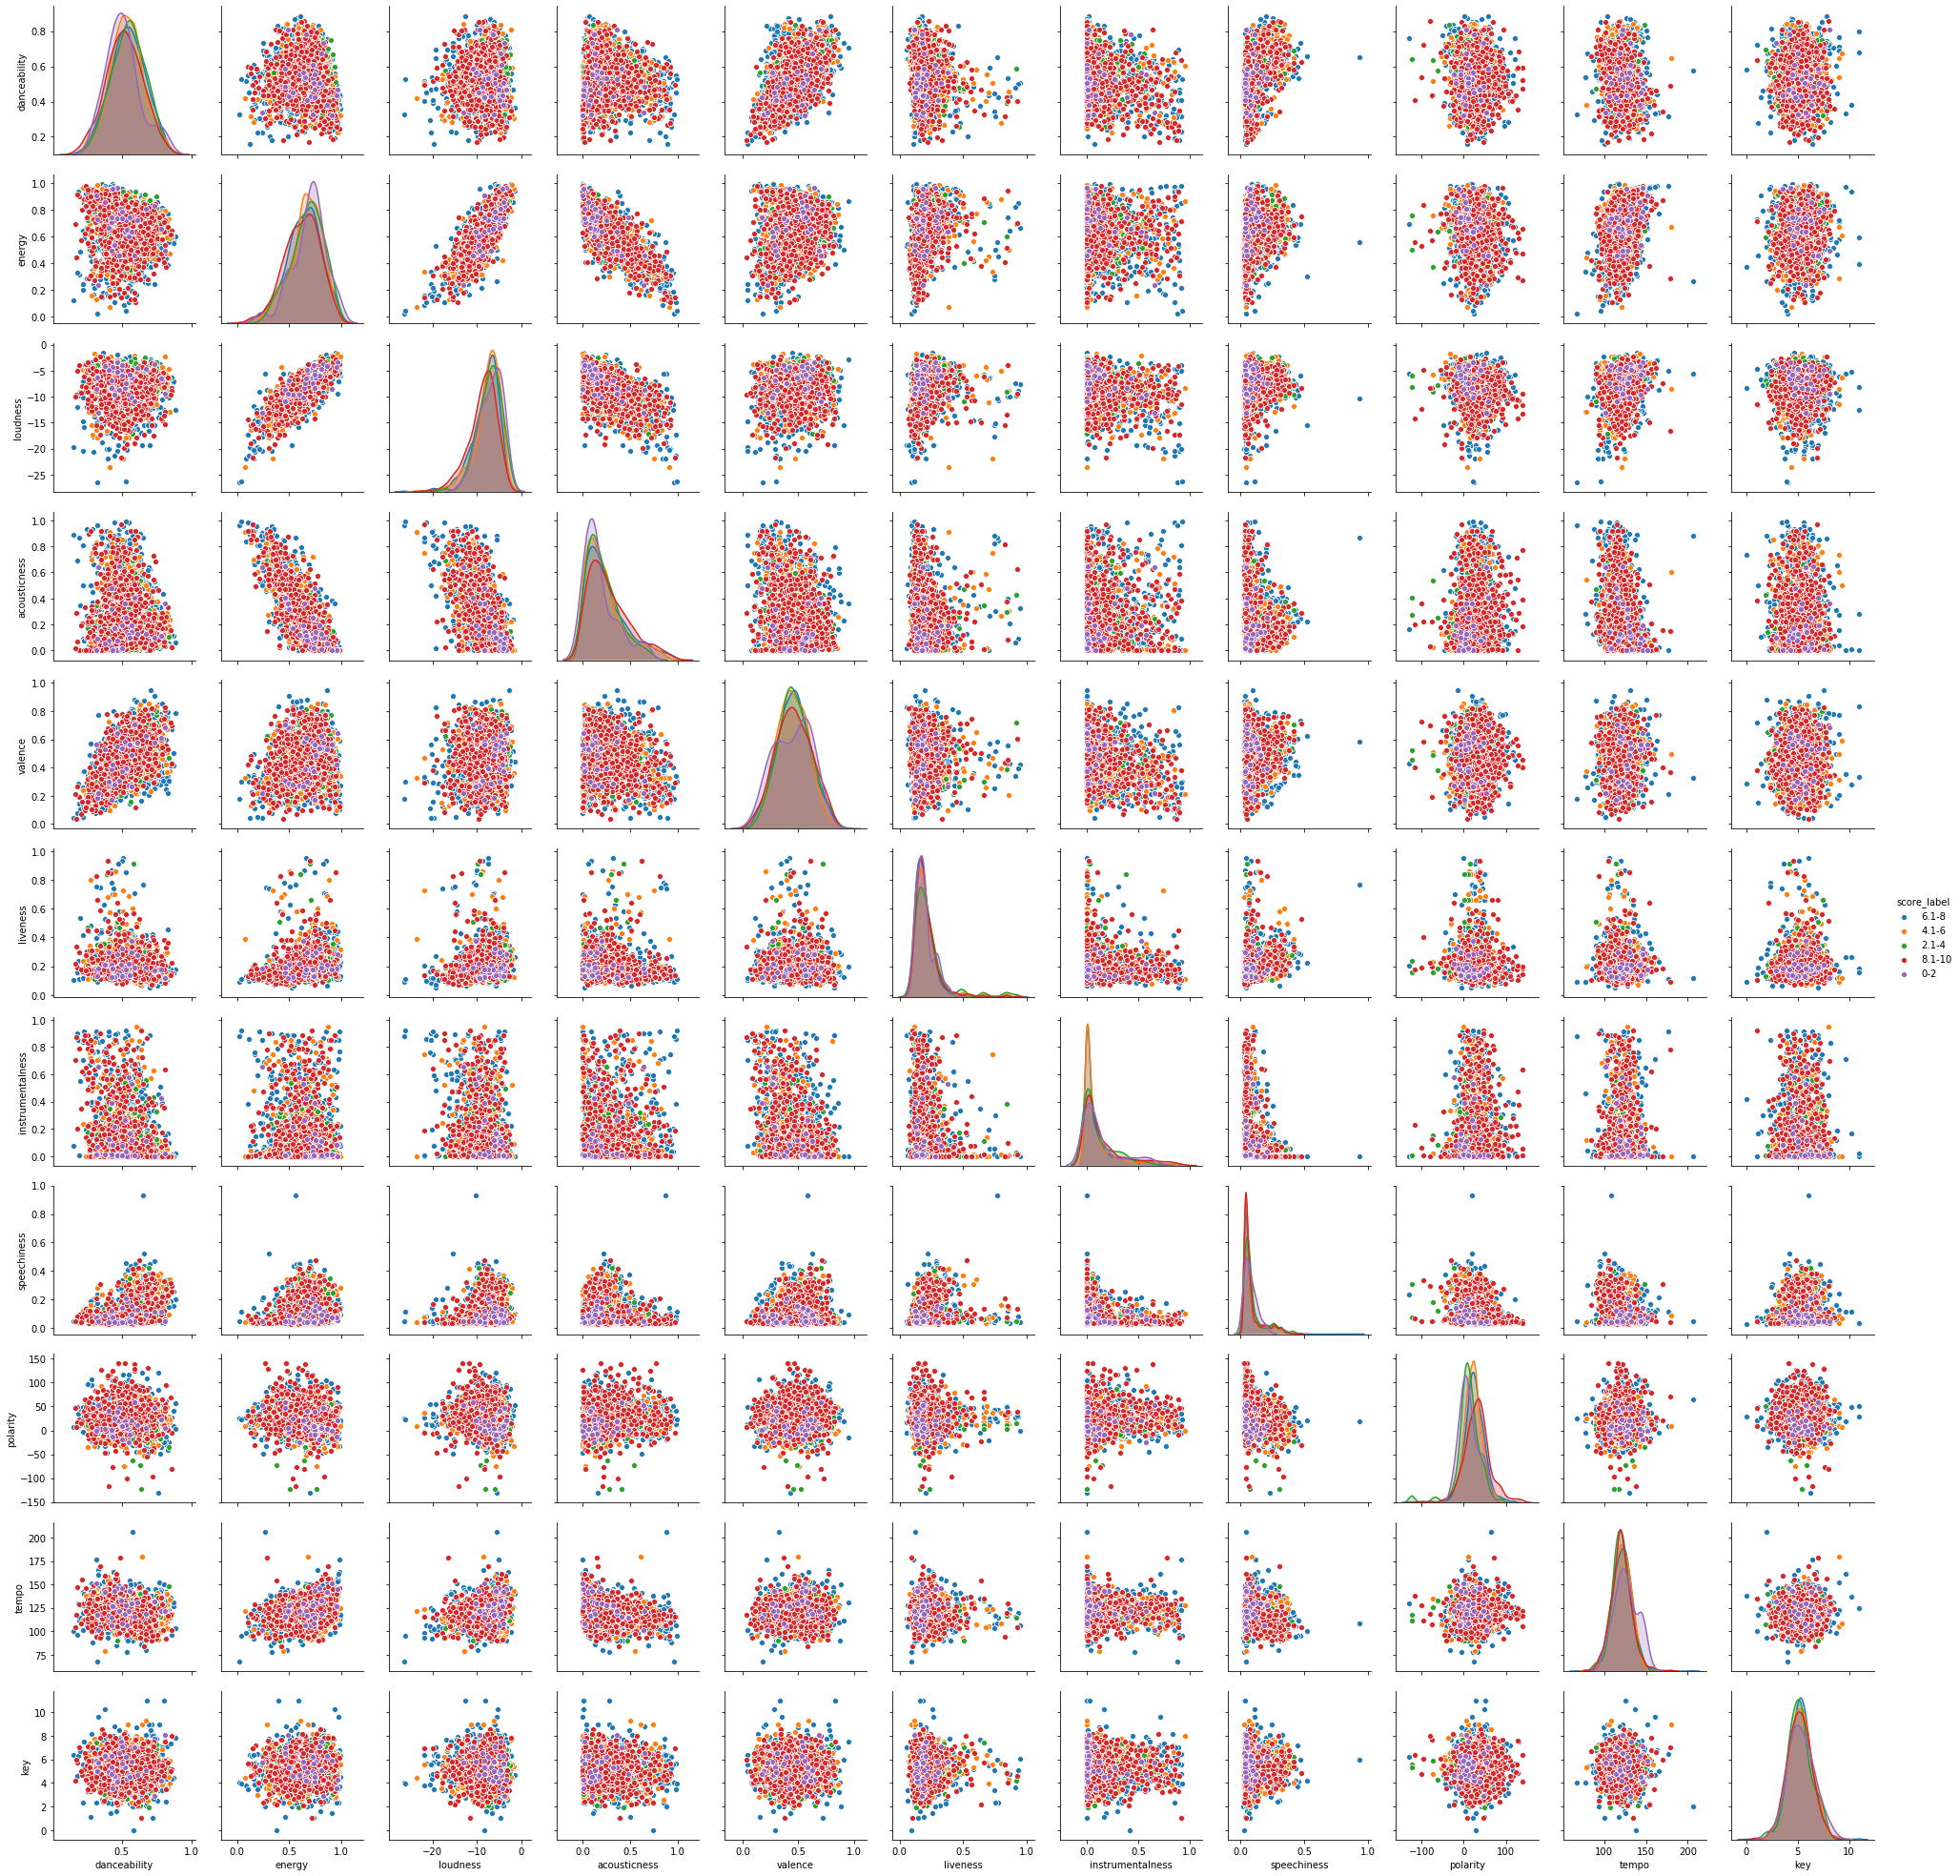

In [26]:
#pair plot of features 
sns.pairplot(acoustics_reviews,vars=['danceability','energy','loudness','acousticness','valence','liveness','instrumentalness','speechiness','polarity','tempo','key'],hue='score_label')

By looking at the pairplots, the majority of them do not seem to have linear relationships. A few variables that do appear to have relationships are `loudness` and `energy` which have a postive relationship, and `acousticness` and `energy` which have a negative relationship. `valence` and `danceability` also seem to have a postive relationship, though not as stronger as the former two variables. Finally, `acousticness` and `loudness` appear to have a steep negative relationship, which is understandable as the two features are opposites. 

### Correlation Matrix of features

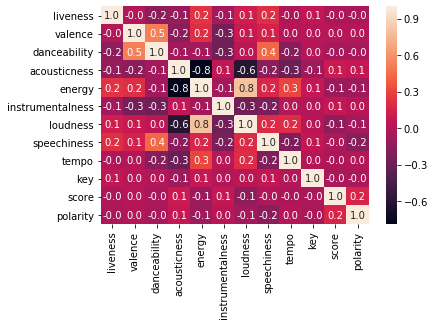

In [27]:
sns.heatmap(acoustics_reviews.corr(), annot=True, fmt='.1f')

As suspected, the relationships we mentioned above are confirmed by their correlation coefficients.

Now that we've done some exploratory analysis, it is evident that our features do not have very many strong linear relationships. So, rather than fitting a linear regression model, we used Primary Component Analysis to see if we could uncover the features in `acoustics_reviews` with the most variance.

Before completing PCA, we wanted to take an initial look at the differences in acoustic features for an album with `score` 10 and an album with `score` 0.

In [28]:
#get all albums with score 10
tens = acoustics_reviews.loc[acoustics_reviews['score']==10.0].reset_index().head()

In [29]:
#get the acoustic scores for the first observation in tens
print(tens.iloc[0])
ten = [0.11035,0.27439,0.4088,0.283127,0.6805,0.0498458,0.08604]
feature = ['liveness','valence','danceability','acousticness','energy','instrumentalness','speechiness']

index                                                             430
album                                                       Homogenic
liveness                                                      0.11035
valence                                                       0.27439
danceability                                                   0.4088
acousticness                                                 0.283127
energy                                                         0.6805
instrumentalness                                            0.0498458
loudness                                                      -7.3163
speechiness                                                   0.08604
tempo                                                         125.306
key                                                               4.3
artist                                                          Björk
genre                                              Electronic,Pop/R&B
score               

In [30]:
#do the same for albums of score 0
zeros = acoustics_reviews.loc[acoustics_reviews['score']==0.0].reset_index().head()
print(zeros.iloc[0])
zero = [0.20701,0.533714,0.496571,0.0124112,0.808143,0.00203322,0.0432429]

index                                                            1738
album                                                       Liz Phair
liveness                                                     0.207071
valence                                                      0.533714
danceability                                                 0.496571
acousticness                                                0.0124112
energy                                                       0.808143
instrumentalness                                           0.00203322
loudness                                                     -4.77121
speechiness                                                 0.0432429
tempo                                                         132.428
key                                                               7.5
artist                                                      Liz Phair
genre                                                            Rock
score               

Text(0.5, 1.0, 'Album of score 10 vs. Album of score 0')

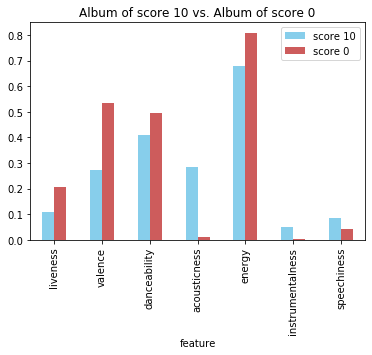

In [31]:
#graph the features compared to each other 
feature = ['liveness','valence','danceability','acousticness','energy','instrumentalness','speechiness']
zero = pd.Series([0.20701,0.533714,0.496571,0.0124112,0.808143,0.00203322,0.0432429],index=feature)
ten = pd.Series([0.11035,0.27439,0.4088,0.283127,0.6805,0.0498458,0.08604],index=feature)
df = pd.DataFrame({"score 10":ten,"score 0":zero})
ax = df.plot.bar(color=["SkyBlue","IndianRed"])
ax.set_xlabel('feature')
ax.set_title('Album of score 10 vs. Album of score 0')

By looking at the plot, the differences are mixed. Score 0 album has higher measures in a few features while the score 10 album leads in others, such as acousticness. That's interesting because we usually assume that upbeat songs tend to have higher ratings. Now that we've taken an intial look, let's do PCA! 

## PCA Implementation 

In [32]:
from sklearn import preprocessing

After fitting PCA models both with and without `polarity`, we noticed that the accuracy score was about 3 percent higher *without* `polarity`. So, we omitted it from our final PCA model, more details are given on `polarity` below. 

In [33]:
#features used in final model
features = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence','loudness','tempo','key']
##features list with polarity: 
#features = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence','loudness','tempo,'key',polarity']
X = acoustics_reviews.loc[:, features].values
Y = acoustics_reviews.loc[:,['score_label']].values

We first split our data into test and training sets, with 20% as test data and 80% as training data.

In [34]:
#splitting our features and score labels into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0) 

Before implementing our model, we made sure to normalize our features as some of them were on extreme scales. Without normalization, feaures with different scales such as `loudness` and `tempo` would carry higher weights and the analysis would be inaccurate. 

In [35]:
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test)  

After normalizing the data, we implemented the a full model to identify the roots of variance in the data.

In [36]:
pca = PCA() 
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)  

In [37]:
explained_variance = pca.explained_variance_ratio_  
print(explained_variance)
#print(pca.components_)

[0.27893796 0.19327698 0.12017227 0.10231145 0.08443864 0.07949656
 0.06441376 0.03539858 0.03307473 0.00847905]


As we can see, the top three components out of ten total carry about 56 percent of the variance in the data. After we fit the model, we broke down each of the features' correlation with the top three primary components.  

In [38]:
print(pd.DataFrame(pca.components_[0:3,:],columns=features,index = ['PC-1','PC-2','PC-3']))

      acousticness  danceability    energy  instrumentalness  liveness  \
PC-1      0.497553     -0.110851 -0.543143          0.194405 -0.153154   
PC-2      0.143398      0.598859 -0.197569         -0.335892 -0.069811   
PC-3      0.090417     -0.210507  0.012746          0.016022  0.681196   

      speechiness   valence  loudness     tempo       key  
PC-1    -0.215387 -0.204092 -0.506256 -0.188157 -0.064463  
PC-2     0.408175  0.413846 -0.097385 -0.341100 -0.019097  
PC-3     0.414180 -0.330715  0.008925 -0.412338  0.179011  


In PC1, the features with the heaviest correlation were `acousticness`, `loudness`, and `energy`. For PC2, we had `danceability`, `instrumentalness`, `speechiness`, and `valence` with highest coefficients. Finally, PC3 had `liveness` and `speechiness` as it's highest correlated features. 

We then created a scree plot and a cum sum variance plot to display the PC components.

Text(0, 0.5, 'Fraction of Variance')

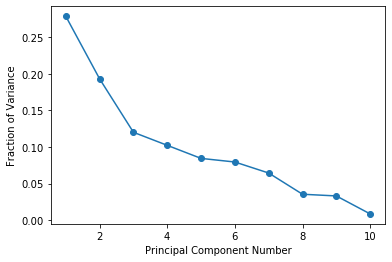

In [39]:
#scree plot
comp = np.arange(1,11)
plt.plot(comp,explained_variance,marker='o')
plt.xlabel('Principal Component Number')
plt.ylabel('Fraction of Variance')

The line elbows at PC3, indicating that the components that follow don't differ that much in the amount of variance they cover.

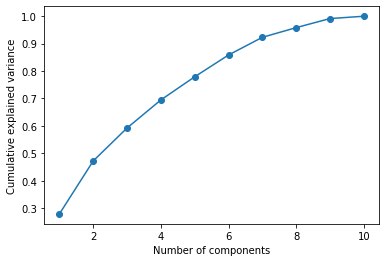

In [40]:
#cumulative variance plot
plt.plot(comp,np.cumsum(explained_variance),marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

Over half of the variance in the data can be explained by the first three PC's.

After several trials in which we fit the PCA model with a different number of components, we found that there is little to no change in accuracy when using more than three PC's. Thus, we fit our final model with three primary components.

In [41]:
pca = PCA(n_components=3)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)

In [42]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=2,random_state=0)  
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test) 

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
from sklearn.metrics import accuracy_score

In [44]:
print('Accuracy' , accuracy_score(Y_test, Y_pred))

Accuracy 0.5541795665634675


As we can see, the accuracy is at about 56 percent which is lower than we wanted it to be. Even when adding more components, the accuracy did not change significantly. This accuracy score tells us that by fitting a PCA model using acoustic features alone, we were able to predict the score label of an album about 56 percent of the time. This result indicates that variation in rating scores cannot be explained only by acoustics. Thus, there must be other factors at work in the scoring of music and we would be interested in digging deeper into what those other factors are in future work. 

## Vader Inaccuracy

We noticed that the accuracy of the models derived from the PCA reduction improved when the polarity was removed from the analysis. Looking at the review with the lowest sentiment gave us some insight on what could be the issue:

In [45]:
most_neg = acoustics_reviews[acoustics_reviews['polarity'] == min(acoustics_reviews['polarity'])]
most_neg

,album,liveness,valence,danceability,acousticness,energy,instrumentalness,loudness,speechiness,tempo,key,artist,genre,score,date,author,review,no_punc,polarity,score_label
3325,Until Death Call My Name,0.20413,0.429325,0.7581,0.16123,0.6939,1.865000e-07,-5.4937,0.2332,129.97495,6.25,YoungBoy Never Broke Again,Rap,6.9,2018-05-09,Sheldon Pearce,"Until Death Call My Name, the debut album from...",until death call my name the debut album from ...,-131.1,6.1-8


The album got the moderately good critic rating of 6.9 while also having the most negative sentiment analysis. Looking into the actual review we see that much of this can be attributed to review's focus on discussing violence that appears in the artist's songs as well as crimes and other negatively associated topics. This brings up potential issues in using this method of tokenized sentiment analysis in an attempt to relate the review sentiment to score and highlights the difficulty in discerning between the opinion and the subject matter that the critic is discussing.

In [46]:
print(most_neg.iloc[0]['review'])

Until Death Call My Name, the debut album from 18-year-old Baton Rouge rogue YoungBoy Never Broke Again, is a meditation on violence, the pangs of conscience, and the ways anticipating an early grave can tint perspective. “I ain’t no bad person, no,” he says in the opening seconds of the record, on “Overdose.” “I ain’t no gangster, ain’t no killer/I ain’t no gangbanger, I’m me/Like everybody make mistakes, that’s life… I just know, shit, until I’m dead I’ma be me.” This is, at least in part, an attempt to reconcile the concept of being “bad” with a childhood plagued by cruelty and self-destruction, which has led YoungBoy to multiple run-ins with the law—including a harrowing alleged assault on a girlfriend that was caught on camera. If his introduction to the album isn’t exactly contrite, it at least offers a moment of clarity. The tracks that follow are packed with allegories on power that lack the emotional depth of his previous work. YoungBoy is a teenager who uses the violence he h

## Is there a better way to analyze critic review sentiment and use it to predict song popularity? 

Because of the potential issues in using a predetermined sentiment lexicon such as VADER we set out to train our own model to predict popularity based on the words used in the Pitchfork review. An album was deemed 'popular' if it had appeared on the Billboard Top 200 list. We used the `albums` dataset that had weekly chart stats for every week.

In [47]:
#reduced df with variables of interest
top_albums = albums[['date', 'artist', 'album', 'rank']].copy()
top_albums.head()

,date,artist,album,rank
0,NaN,NaN,NaN,NaN
1,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1.0
2,2019-01-19,21 Savage,I Am > I Was,2.0
3,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3.0
4,2019-01-19,Meek Mill,Championships,4.0


In order to check whether an album has appeared in `albums` we created a unique identifier with album and artist name in both datasets:

In [48]:
#lowercase and remove punct from album name and artist to create identifiers
acoustics_reviews['album_ID'] = acoustics_reviews['artist'].str.lower().str.replace(punct_re, '').str.strip().str.replace(' ', '') + acoustics_reviews['album'].str.lower().str.replace(punct_re, '').str.strip().str.replace(' ', '')
top_albums['album_ID'] = top_albums['artist'].str.lower().str.replace(punct_re, '').str.strip().str.replace(' ', '') + top_albums['album'].str.lower().str.replace(punct_re, '').str.strip().str.replace(' ', '')

New column `billboard` added to `acoustics_reviews` that indicates whether the album has appeared on the Billboard Top 200.

In [49]:
#new column titled 'billboard' that indicates if album in acoustics_reviews is in 'albums'
acoustics_reviews['billboard'] = acoustics_reviews['album_ID'].isin(top_albums['album_ID']).astype(int)
hits = sum(acoustics_reviews['billboard'])
print(f"There are {hits} out of {len(acoustics_reviews)} albums in our dataset 'acoustics_reviews' that have made the Billboard Top 200 since 1963.")

There are 2115 out of 3229 albums in our dataset 'acoustics_reviews' that have made the Billboard Top 200 since 1963.


This is about 65.5% which initially seemed a little high. It could be attributed to various factors but we think it has to do with where the subset of our dataset is from; it was merged from albums that came from the Spotify acoustic data and was also reviewed by in Pitchfork. We think these albums would be more likely to have more reviews for albums relevent to pop culture and thus be more likely to show up on Billboard Top 200.

## Setting up the Classification Model

Our model uses the `NaiveBayesClassifier` from the `nltk` package. Implementation was based off work done in Homework 3 as well as [this](http://blog.chapagain.com.np/python-nltk-sentiment-analysis-on-movie-reviews-natural-language-processing-nlp/) tutorial by Mukesh Chapagain.

In [50]:
#Create a subset of the dataset that ignores irrelevant variables
reviews_nltk = acoustics_reviews[['artist', 'album', 'genre', 'review', 'billboard']]
reviews_nltk.head()

,artist,album,genre,review,billboard
0,!!!,Myth Takes,Rock,With his midriff-baring t-shirts and loose-lim...,0
1,...And You Will Know Us by the Trail of Dead,So Divided,Rock,In the four years since the release of their m...,1
2,...And You Will Know Us by the Trail of Dead,Worlds Apart,Rock,Did Source Tags & Codes deserve a 10.0? That's...,1
3,2 Chainz,Pretty Girls Like Trap Music,Rap,The last song on Pretty Girls Like Trap Music ...,1
4,New Order,Get Ready,Rock,It's been a long time since we've heard from N...,1


In order to form the bag-of-words and dictionaries that the model can read the raw review strings need to be normalized and processed. This includes removing whitespace, punctuation, numbers and converting all letters to lowercase. In addition, stop words from the `nltk.corpus` package were removed and the strings were tokenized to create lists of key words.

In [51]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
# Create new column for key words in review
reviews_nltk['key_words'] = ''
reviews_nltk['key_words'] = np.nan

# Covert to lowercase and remove leading/trailing whitespace
reviews_nltk['key_words'] = reviews_nltk['review'].str.lower().str.strip()

# Remove punctuation
punct_regex = r'[\W]'
reviews_nltk['key_words'] = reviews_nltk['key_words'].str.replace(punct_regex, ' ')

# Remove numbers
num_regex = r'[\d]'
reviews_nltk['key_words'] = reviews_nltk['key_words'].str.replace(num_regex, ' ')

# Get rid of stop words
reviews_nltk['key_words'] = (reviews_nltk['key_words'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words])))

# Tokenize the reviews to get list of key words
reviews_nltk['key_words'] = (reviews_nltk['key_words'].apply(word_tokenize))

reviews_nltk.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,artist,album,genre,review,billboard,key_words
0,!!!,Myth Takes,Rock,With his midriff-baring t-shirts and loose-lim...,0,"[midriff, baring, shirts, loose, limbed, dance..."
1,...And You Will Know Us by the Trail of Dead,So Divided,Rock,In the four years since the release of their m...,1,"[four, years, since, release, monumental, sour..."
2,...And You Will Know Us by the Trail of Dead,Worlds Apart,Rock,Did Source Tags & Codes deserve a 10.0? That's...,1,"[source, tags, codes, deserve, say, matt, lema..."
3,2 Chainz,Pretty Girls Like Trap Music,Rap,The last song on Pretty Girls Like Trap Music ...,1,"[last, song, pretty, girls, like, trap, music,..."
4,New Order,Get Ready,Rock,It's been a long time since we've heard from N...,1,"[long, time, since, heard, new, order, full, e..."


Bags of words for each category of billboard appearance were created. These are simply lists of every keyword that appears in each category through the full set of reviews.

In [53]:
#create bag of words for each group (on billboard vs. not)
on_billboard = []
for keywords in reviews_nltk[reviews_nltk['billboard'] == 1]['key_words']:
    on_billboard.append(keywords)

off_billboard = []
for keywords in reviews_nltk[reviews_nltk['billboard'] == 0]['key_words']:
    off_billboard.append(keywords)

Next we need to create dictionaries for each category where each word is a key and the value indicates whether it has appeared on Billboard or not:

In [54]:
def bag_of_words(words):
    words_clean = []
    for word in words:
        words_clean.append(word)
    words_dictionary = dict([word, True] for word in words_clean)
    return words_dictionary

In [55]:
on_billboard_set = []
for words in on_billboard:
    on_billboard_set.append((bag_of_words(words), 'on'))
    
off_billboard_set = []
for words in off_billboard:
    off_billboard_set.append((bag_of_words(words), 'off'))

The data is then split into 75% training and 25% testing for each category. The full sets of testing and training data are the sums of this split. This ensures that there is a proportional amount of each category in the training data.

In [56]:
from sklearn.model_selection import train_test_split
on_tr, on_te = train_test_split(on_billboard_set, test_size = .25, train_size = .75)
off_tr, off_te = train_test_split(off_billboard_set, test_size = .25, train_size = .75)
data_tr = on_tr + off_tr
data_te = on_te + off_te

**Training Naive Bayes Classifier from NLTK and testing accuracy:**

In [57]:
from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(data_tr)
accuracy = classify.accuracy(classifier, data_te)
print(f'This model has an accuracy of {accuracy*100}%., ')

This model has an accuracy of 71.03960396039604%., 


In [58]:
#return the most informative key words
print(classifier.show_most_informative_features(10))

Most Informative Features
               sheffield = True              off : on     =     14.6 : 1.0
             brainfeeder = True              off : on     =     14.6 : 1.0
                mutating = True              off : on     =     14.6 : 1.0
               shivering = True              off : on     =     14.6 : 1.0
                shackles = True              off : on     =     12.0 : 1.0
           improvisation = True              off : on     =     11.7 : 1.0
                     slo = True              off : on     =     10.8 : 1.0
             convictions = True              off : on     =     10.8 : 1.0
                  saucer = True              off : on     =     10.8 : 1.0
                 gamelan = True              off : on     =     10.8 : 1.0
None


## Submission

You are required to submit two files:

1. Submit your completed writeup as a PDF to gradescope.  You should address all of the components described above, adhering to the page limit, and include any figures and tables that are necessary. (Make sure to number figures and tables and include informative captions.)

2.  Submit a complete jupyter notebook with all of your analyses to the okpy server.  For your submission, use **this jupyter notebook** as a template (remove the instructions, replacing them with your analysis).  We should be able to reproduce all of your results by running your notebook. 

Before you submit the notebook, make sure that you select from the top menu `Kernel -> Restart & Clear Output` followed by `Cell -> Run All`. Verify that all computations execute correctly. There should be no errors when we run your notebook. 

In [59]:
# These lines help load your submission for grading.
from client.api.notebook import Notebook
ok = Notebook('final-project.ok')
_ = ok.auth(inline=True)

Assignment: final-project
OK, version v1.14.15

Successfully logged in as jakekaihewalu@ucsb.edu


In [ ]:
_ = ok.submit()